# Final Project (ICHIMOKU Trading Strategy)

In [13]:
import pandas_datareader.data as web
from mpl_finance import candlestick_ohlc
import matplotlib.dates as dates
import datetime
import plotly.offline as py
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
py.init_notebook_mode(connected=True)

In [14]:
#get stock information from web
start = datetime.datetime(2000,1,1)
end = datetime.date.today()
d=web.DataReader("600797.SS", 'yahoo', start, end)
d['Dates'] = dates.date2num((d.index))

In [15]:
##caculate 5 ICHIMOKU elements
# Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
nine_period_high = d['High'].rolling(window= 9).max()
nine_period_low = d['Low'].rolling(window= 9).min()
d['tenkan_sen'] = (nine_period_high + nine_period_low) /2
# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = d['High'].rolling(window=26).max()
period26_low = d['Low'].rolling(window=26).min()
d['kijun_sen'] = (period26_high + period26_low) / 2
# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)
# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = d['High'].rolling(window=52).max()
period52_low = d['Low'].rolling(window=52).min()
d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(52)
# The most current closing price plotted 26 time periods behind 
d['chikou_span'] = d['Close'].shift(-26)

In [16]:
##PART ONE : plot simple candlestick chart of ichimoku model
trace = go.Candlestick(x=d.index,
                       open=d['Open'],
                       high=d['High'],
                       low=d['Low'],
                       close=d['Close'])
data = [trace]
py.iplot(data, filename='simple_candlestick.html')

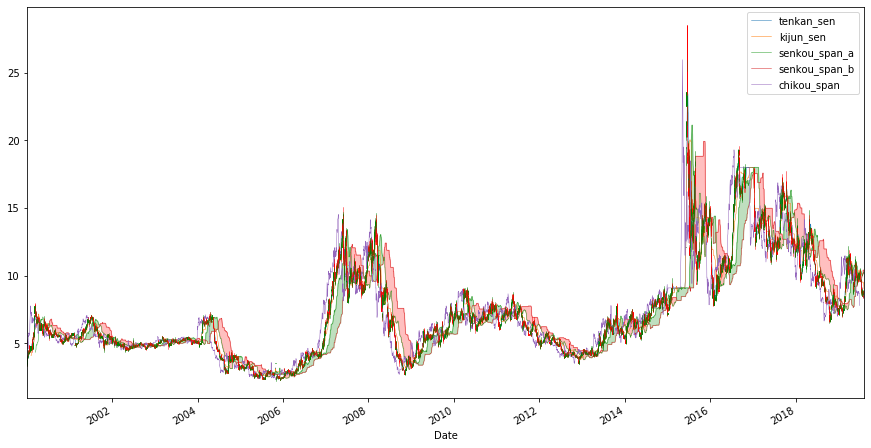

In [17]:
##PART TWO : Plot complete chart of ichimoku model: Ichimoku Cloud(Set colours for up and down candles)
# Plot candlestick, along with Ichimoku elements
def re_arrange(var):
    return [tuple(x) for x in var.values]
quotes = re_arrange(d[['Dates','Open','High','Low','Close']])
fig, ax = plt.subplots(figsize=(15,8))
d[['tenkan_sen','kijun_sen','senkou_span_a','senkou_span_b','chikou_span']].plot(ax=ax, linewidth=0.5)
candlestick_ohlc(ax, quotes, width=1.0, colorup='g', colordown='r');
# create a list to hold dictionary with data for our first series to plot (the candlestick elements)
data1 = [ dict(
        type = 'candlestick',
        open = d.Open,
        high = d.High,
        low = d.Low,
        close = d.Close,
        x = d.index,
        yaxis = 'y2',
        name = 'F',
)]
# create  "Figure" object which consists of data to plot and layout settings
fig = dict( data=data1, layout={} )
# Assign various seeting and choices - background colour, range selector etc
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )
fig['layout']['height'] = 900
fig['layout']['width'] = 1300
# Populate the "rangeselector" object with necessary settings
rangeselector=dict(
        visible = True,
        x = 0, y = 0.9,
        bgcolor = 'rgba(150, 200, 250, 0.4)',
        font = dict( size = 13 ),
        buttons=list([
                dict(count=1,
                     label='reset',
                     step='all'),
                dict(count=1,
                     label='1yr',
                     step='year',
                     stepmode='backward'),
                dict(count=3,
                     label='3 mo',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='1 mo',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
        ]))
    
fig['layout']['xaxis']['rangeselector'] = rangeselector
# Append the Ichimoku elements to our plot
def append_elements(lin,col):
    fig['data'].append( dict( x=d[lin].index, y=d[lin], type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = col ),
                         yaxis = 'y2', name=lin ) )
append_elements('tenkan_sen','#33BDFF')
append_elements('kijun_sen','#F1F316')
append_elements('senkou_span_a','#228B22')
append_elements('senkou_span_b','#FF3342')
append_elements('chikou_span','#D105F5')              
# add color to our plot
def add_color(x,y1,y2):
    plt.fill_between(x, y1, y2 , y1>y2, color='green', alpha=.25)
    plt.fill_between(x, y1, y2 , y1<y2, color='red',  alpha=.25)
add_color(d.index,d['senkou_span_a'],d['senkou_span_b'])
py.iplot( fig, filename = 'candlestick-ichimoku.html' )

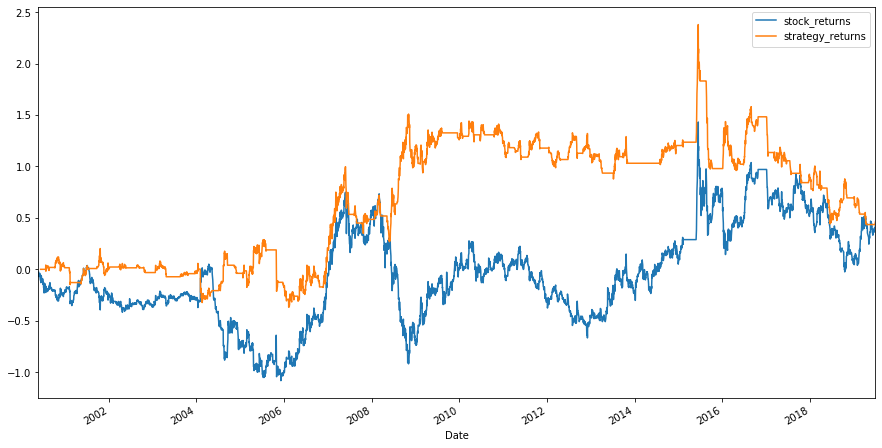

In [18]:
##PART THREE : def a function to show whether the strategy return is higher than stock return
def ichimoku(stock, start, end):
    d=web.DataReader(stock, 'yahoo', start, end)[['Open','High','Low','Close']]
    ##caculate 5 ICHIMOKU elements
    # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
    nine_period_high = d['High'].rolling(window= 9).max()
    nine_period_low = d['Low'].rolling(window= 9).min()
    d['tenkan_sen'] = (nine_period_high + nine_period_low) /2
    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    period26_high = d['High'].rolling(window=26).max()
    period26_low = d['Low'].rolling(window=26).min()
    d['kijun_sen'] = (period26_high + period26_low) / 2
    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)
    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    period52_high = d['High'].rolling(window=52).max()
    period52_low = d['Low'].rolling(window=52).min()
    d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(52)
    # The most current closing price plotted 26 time periods behind 
    d['chikou_span'] = d['Close'].shift(-26)
    ##trading strategy
    d.dropna(inplace=True)
    #identify whether the price is inside or outside the cloud
    d['above_cloud'] = 0
    d['above_cloud'] = np.where((d['Low'] > d['senkou_span_a'])  & (d['Low'] > d['senkou_span_b'] ), 1, d['above_cloud'])
    d['above_cloud'] = np.where((d['High'] < d['senkou_span_a']) & (d['High'] < d['senkou_span_b']), -1, d['above_cloud'])
    #identify whether Senkou Span A is above or below Senkou Span B
    d['A_above_B'] = np.where((d['senkou_span_a'] > d['senkou_span_b']), 1, -1)
    #identify if T_line is above or below K_line(1:above  -1:below)
    d['tenkan_kiju_cross'] = np.NaN
    d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) <= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] > d['kijun_sen']), 1, d['tenkan_kiju_cross'])
    d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) >= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] < d['kijun_sen']), -1, d['tenkan_kiju_cross'])
    #identify if P_line is above or below T_line(1:above  -1:below)
    d['price_tenkan_cross'] = np.NaN
    d['price_tenkan_cross'] = np.where((d['Open'].shift(1) <= d['tenkan_sen'].shift(1)) & (d['Open'] > d['tenkan_sen']), 1, d['price_tenkan_cross'])
    d['price_tenkan_cross'] = np.where((d['Open'].shift(1) >= d['tenkan_sen'].shift(1)) & (d['Open'] < d['tenkan_sen']), -1, d['price_tenkan_cross'])
    #buy & sell the stock
    d['buy'] = np.NaN
    d['buy'] = np.where((d['above_cloud'].shift(1) == 1) & (d['A_above_B'].shift(1) == 1) & ((d['tenkan_kiju_cross'].shift(1) == 1) | (d['price_tenkan_cross'].shift(1) == 1)), 1, d['buy'])
    d['buy'] = np.where(d['tenkan_kiju_cross'].shift(1) == -1, 0, d['buy'])
    d['buy'].ffill(inplace=True)
    d['sell'] = np.NaN
    d['sell'] = np.where((d['above_cloud'].shift(1) == -1) & (d['A_above_B'].shift(1) == -1) & ((d['tenkan_kiju_cross'].shift(1) == -1) | (d['price_tenkan_cross'].shift(1) == -1)), -1, d['sell'])
    d['sell'] = np.where(d['tenkan_kiju_cross'].shift(1) == 1, 0, d['sell'])
    d['sell'].ffill(inplace=True)
    
    d['net_strategy_position'] = d['buy'] + d['sell']
    d['stock_returns'] = np.log(d['Open']) - np.log(d['Open'].shift(1))
    d['strategy_returns'] = d['stock_returns'] * d['net_strategy_position']
    d[['stock_returns','strategy_returns']].cumsum().plot(figsize=(15,8))
#Set variables    
stock = '600797.SS'
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()
ichimoku(stock, start, end)